## 1D CNN Time Series Classification

### Importing Required Libraries and Data

In [24]:
import pandas as pd
import numpy as np
#to plot the data
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
#import matplotlib as mpl
#mpl.rcParams.update(mpl.rcParamsDefault)
import time
import os
os.chdir("/Users/tomxu/Documents/NASA-Jet-Engine-Maintenance/Data/CMaps/")
from sklearn.preprocessing import MinMaxScaler #to normalize data
from sklearn.metrics import classification_report, confusion_matrix, roc_curve
from sklearn.metrics import f1_score, roc_auc_score, accuracy_score, precision_score, recall_score
from sklearn.utils import class_weight
#for deep learning
import tensorflow.keras
import tensorflow.keras.backend as k
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Activation, Masking, Dropout, Conv1D, GlobalAveragePooling1D, MaxPooling1D
from tensorflow.keras.optimizers import RMSprop, Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import History
from tensorflow.keras import callbacks
from tensorflow.keras.utils import to_categorical

In [25]:
def prepare_data(drop_cols = True):
    dependent_var = ['RUL']
    index_columns_names =  ["UnitNumber","Cycle"]
    operational_settings_columns_names = ["OpSet"+str(i) for i in range(1,4)]
    sensor_measure_columns_names =["SensorMeasure"+str(i) for i in range(1,22)]
    input_file_column_names = index_columns_names + operational_settings_columns_names + sensor_measure_columns_names
    cols_to_drop = ['OpSet3', 'SensorMeasure1', 'SensorMeasure5', 'SensorMeasure6', 'SensorMeasure10',
                    'SensorMeasure14', 'SensorMeasure16', 'SensorMeasure18', 'SensorMeasure19']
    df_train = pd.read_csv('train_FD001.txt',delim_whitespace=True,names=input_file_column_names)
    rul = pd.DataFrame(df_train.groupby('UnitNumber')['Cycle'].max()).reset_index()
    rul.columns = ['UnitNumber', 'max']
    df_train = df_train.merge(rul, on=['UnitNumber'], how='left')
    df_train['RUL'] = df_train['max'] - df_train['Cycle']
    df_train.drop('max', axis=1, inplace=True)
    df_train['failure_lbl_1'] = [1 if i < 50 else 0 for i in df_train.RUL]
    df_train['failure_lbl_2'] = df_train['failure_lbl_1']
    df_train['failure_lbl_2']=np.where(df_train.RUL < 25, 2, df_train['failure_lbl_2'])
    df_test = pd.read_csv('test_FD001.txt', delim_whitespace=True, names=input_file_column_names)    
    if(drop_cols == True):
        df_train = df_train.drop(cols_to_drop, axis = 1)
        df_test = df_test.drop(cols_to_drop, axis = 1)
    y_true = pd.read_csv('RUL_FD001.txt', delim_whitespace=True,names=["RUL"])
    y_true["UnitNumber"] = y_true.index
    y_true['failure_lbl_1'] = [1 if i < 50 else 0 for i in y_true.RUL]
    y_true['failure_lbl_2'] = y_true['failure_lbl_1']
    y_true['failure_lbl_2'] = np.where(y_true.RUL < 25, 2, y_true['failure_lbl_2'])    
    return df_train, df_test, y_true

In [26]:
df_train, df_test, y_true = prepare_data(drop_cols=True)
df_train.shape, df_test.shape, y_true.shape

((20631, 20), (13096, 17), (100, 4))

In [27]:
feats = df_train.columns.drop(['UnitNumber', 'Cycle', 'RUL', 'failure_lbl_1', 'failure_lbl_2'])

In [28]:
min_max_scaler = MinMaxScaler(feature_range=(-1,1))
df_train[feats] = min_max_scaler.fit_transform(df_train[feats])
df_test[feats] = min_max_scaler.transform(df_test[feats])

In [29]:
df_train.head()

,UnitNumber,Cycle,OpSet1,OpSet2,SensorMeasure2,SensorMeasure3,SensorMeasure4,SensorMeasure7,SensorMeasure8,SensorMeasure9,SensorMeasure11,SensorMeasure12,SensorMeasure13,SensorMeasure15,SensorMeasure17,SensorMeasure20,SensorMeasure21,RUL,failure_lbl_1,failure_lbl_2
0,1,1,-0.080460,-0.666667,-0.632530,-0.186396,-0.380486,0.452496,-0.515152,-0.780490,-0.261905,0.266525,-0.588235,-0.272028,-0.333333,0.426357,0.449323,191,0,0
1,1,2,0.218391,-0.500000,-0.433735,-0.093961,-0.294733,0.256039,-0.575758,-0.799515,-0.238095,0.530917,-0.441176,-0.177376,-0.333333,0.333333,0.462027,190,0,0
2,1,3,-0.494253,0.500000,-0.313253,-0.260955,-0.258947,0.420290,-0.454545,-0.719914,-0.500000,0.590618,-0.558824,-0.285110,-0.666667,0.255814,0.242751,189,0,0
3,1,4,0.080460,0.000000,-0.313253,-0.487683,-0.337610,0.481481,-0.363636,-0.750965,-0.666667,0.778252,-0.411765,-0.666795,-0.333333,0.147287,0.324772,188,0,0
4,1,5,-0.218391,-0.333333,-0.301205,-0.485066,-0.190749,0.336554,-0.515152,-0.700081,-0.488095,0.492537,-0.529412,-0.195845,-0.166667,0.178295,0.409003,187,0,0


In [30]:
df_test.head()

,UnitNumber,Cycle,OpSet1,OpSet2,SensorMeasure2,SensorMeasure3,SensorMeasure4,SensorMeasure7,SensorMeasure8,SensorMeasure9,SensorMeasure11,SensorMeasure12,SensorMeasure13,SensorMeasure15,SensorMeasure17,SensorMeasure20,SensorMeasure21
0,1,1,0.264368,0.500000,0.090361,-0.378679,-0.461175,0.304348,-0.575758,-0.744773,-0.583333,0.292111,-0.558824,-0.382070,-0.333333,0.116279,0.323667
1,1,2,-0.310345,-0.500000,-0.698795,-0.240898,-0.555368,0.610306,-0.666667,-0.706632,-0.226190,0.479744,-0.470588,-0.573682,-0.166667,0.364341,0.373654
2,1,3,0.034483,0.166667,-0.246988,-0.306736,-0.355503,0.371981,-0.545455,-0.683837,-0.226190,0.398721,-0.558824,-0.082724,-0.166667,0.457364,0.442695
3,1,4,0.482759,0.000000,-0.259036,-0.429693,-0.183997,0.359098,-0.606061,-0.788567,-0.488095,0.147122,-0.500000,-0.485956,-0.500000,0.333333,0.324220
4,1,5,0.160920,0.000000,-0.216867,-0.295836,-0.335922,0.388084,-0.666667,-0.795208,-0.452381,0.475480,-0.558824,-0.398230,-0.666667,0.317829,0.432753


In [31]:
y_true.head()

,RUL,UnitNumber,failure_lbl_1,failure_lbl_2
0,112,0,0,0
1,98,1,0,0
2,69,2,0,0
3,82,3,0,0
4,91,4,0,0


1D CNN expects an input in the shape of a numpy array of 3 dimensions and I will need to convert train and test data accordingly.

In [32]:
def gen_train(id_df, seq_length, seq_cols):
    """
        repeated overlay of chunks of size seq_length to prepare (samples, time steps, features)
        id_df = train dataframe
        seq_length = look back period
        seq_cols = feature columns
    """        
    data_array = id_df[seq_cols].values
    num_elements = data_array.shape[0]
    lstm_array=[]    
    for start, stop in zip(range(0, num_elements-seq_length+1), range(seq_length, num_elements+1)):
        lstm_array.append(data_array[start:stop, :])    
    return np.array(lstm_array)

In [64]:
def gen_target(id_df, seq_length, label):
    # label is the column name string for target
    data_array = id_df[label].values
    num_elements = data_array.shape[0]
    return data_array[seq_length-1:num_elements+1]

In [34]:
def gen_test(id_df, seq_length, seq_cols, mask_value):
    """
        function to prepare test data into (samples, time steps, features)
        function only returns last sequence of data for every unit
        id_df = test dataframe
        seq_length = look back period
        seq_cols = feature columns
    """
    df_mask = pd.DataFrame(np.zeros((seq_length-1,id_df.shape[1])),columns=id_df.columns)
    df_mask[:] = mask_value    
    id_df1 = pd.concat([df_mask, id_df],ignore_index=True)    
    data_array = id_df1[seq_cols].values
    num_elements = data_array.shape[0]
    lstm_array=[]    
    start = num_elements-seq_length
    stop = num_elements    
    lstm_array.append(data_array[start:stop, :])    
    return np.array(lstm_array)

### Function to Print results

In [35]:
def print_results(y_test, y_pred, multi_class = False):    
    #f1-score
    if multi_class == True:
        f1 = f1_score(y_test, y_pred, average="macro")
    else:
        f1 = f1_score(y_test, y_pred)
    print("F1 Score: ", f1)
    print(classification_report(y_test, y_pred))    
    conf_matrix = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(12,12))
    plt.subplot(221)
    sns.heatmap(conf_matrix, fmt="d", annot=True, cmap='Blues')
    b, t = plt.ylim()
    plt.ylim(b+0.5, t-0.5)
    plt.title('Confusion Matrix')
    plt.ylabel('True Values')
    plt.xlabel('Predicted Values')
    #roc_auc_score
    if multi_class == False:
        model_roc_auc = roc_auc_score(y_test, y_pred) 
        print ("Area Under Curve : ", model_roc_auc, "\n")
        fpr,tpr,thresholds = roc_curve(y_test, y_pred)
        gmeans = np.sqrt(tpr * (1-fpr))
        ix = np.argmax(gmeans)
        threshold = np.round(thresholds[ix],3)
        plt.subplot(222)
        plt.plot(fpr, tpr, color='darkorange', lw=1, label = "Auc : %.3f" %model_roc_auc)
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        plt.scatter(fpr[ix], tpr[ix], marker='o', color='black', label='Best Threshold:' + str(threshold))
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver operating characteristic')
        plt.legend(loc="lower right")

## Binary Classification

In [36]:
sequence_length = 50
mask_value = 0
label = "failure_lbl_1"


Let's prepare data using above functions.

In [37]:
#generate train
train1 = gen_train(df_train[df_train['UnitNumber']==1], sequence_length, feats)
print(train1.shape)
x_train=np.concatenate(list(list(gen_train(df_train[df_train['UnitNumber']==unit], sequence_length, feats)) for unit in df_train['UnitNumber'].unique()))
print(x_train.shape)

(143, 50, 15)
(15731, 50, 15)


In [38]:
#generate target of train
y_train = np.concatenate(list(list(gen_target(df_train[df_train['UnitNumber']==unit], sequence_length, label)) for unit in df_train['UnitNumber'].unique()))
y_train.shape

(15731,)

In [39]:
#generate test
x_test=np.concatenate(list(list(gen_test(df_test[df_test['UnitNumber']==unit], sequence_length, feats, mask_value)) for unit in df_test['UnitNumber'].unique()))
print(x_test.shape)

(100, 50, 15)


In [40]:
#true target of test 
y_test = y_true.RUL.values
y_test.shape

(100,)

In [41]:
nb_features = x_train.shape[2]
nb_out = 1

In [42]:
nb_features

15

In [43]:
cls_wt= class_weight.compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
cls_wt = {i : cls_wt[i] for i in range(2)}
cls_wt

{0: 0.7329699002888826, 1: 1.5731}

### 1D CNN Model

In [44]:
history = History()
model = Sequential()
model.add(Conv1D(50, 6, activation = 'relu', input_shape=(sequence_length, nb_features)))
model.add(Conv1D(50, 6, activation = 'relu'))
model.add(MaxPooling1D(3))
model.add(Conv1D(100, 6, activation = 'relu'))
model.add(Conv1D(100, 6, activation = 'relu'))
model.add(GlobalAveragePooling1D())
model.add(Dropout(0.5))
model.add(Dense(units=1, activation='sigmoid'))
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_4 (Conv1D)            (None, 45, 50)            4550      
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 40, 50)            15050     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 13, 50)            0         
_________________________________________________________________
conv1d_6 (Conv1D)            (None, 8, 100)            30100     
_________________________________________________________________
conv1d_7 (Conv1D)            (None, 3, 100)            60100     
_________________________________________________________________
global_average_pooling1d_1 ( (None, 100)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)              

In [45]:
%%time
# fit the model
model.fit(x_train, y_train, epochs=10, batch_size=64, validation_split=0.1, verbose=1, class_weight=cls_wt,
          callbacks=[history, callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=3,
                                                      verbose=0, mode='auto')])

Epoch 1/10
  1/222 [..............................] - ETA: 1:05 - loss: 0.7132 - accuracy: 0.3906

2022-11-05 18:19:34.984434: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


222/222 [==============================] - ETA: 0s - loss: 0.2276 - accuracy: 0.9077

2022-11-05 18:19:38.579535: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


222/222 [==============================] - 4s 17ms/step - loss: 0.2276 - accuracy: 0.9077 - val_loss: 0.1806 - val_accuracy: 0.9276
Epoch 2/10
222/222 [==============================] - 3s 16ms/step - loss: 0.1060 - accuracy: 0.9618 - val_loss: 0.2553 - val_accuracy: 0.9066
Epoch 3/10
222/222 [==============================] - 3s 16ms/step - loss: 0.0519 - accuracy: 0.9799 - val_loss: 0.2049 - val_accuracy: 0.9454
Epoch 4/10
222/222 [==============================] - 3s 16ms/step - loss: 0.0379 - accuracy: 0.9847 - val_loss: 0.2455 - val_accuracy: 0.9206
CPU times: user 11 s, sys: 6.11 s, total: 17.1 s
Wall time: 14.4 s


Text(0.5, 1.0, 'Loss')

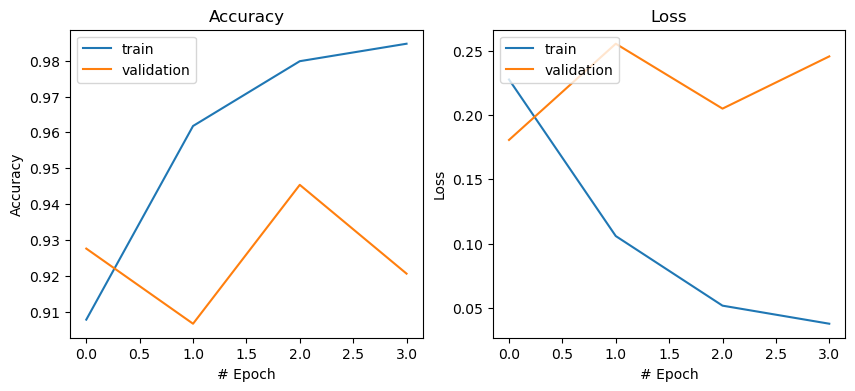

In [46]:
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (10, 4))
# Accuracy
ax[0].plot(history.history['accuracy'])
ax[0].plot(history.history['val_accuracy'])
ax[0].set_ylabel('Accuracy')
ax[0].set_xlabel('# Epoch')
ax[0].legend(['train', 'validation'], loc='upper left')
ax[0].set_title('Accuracy')
# Loss
ax[1].plot(history.history['loss'])
ax[1].plot(history.history['val_loss'])
ax[1].set_ylabel('Loss')
ax[1].set_xlabel('# Epoch')
ax[1].legend(['train', 'validation'], loc='upper left')
ax[1].set_title('Loss')

2022-11-05 18:19:49.539925: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


F1 Score:  0.9032258064516129
              precision    recall  f1-score   support

           0       0.97      0.94      0.96        70
           1       0.88      0.93      0.90        30

    accuracy                           0.94       100
   macro avg       0.92      0.94      0.93       100
weighted avg       0.94      0.94      0.94       100

Area Under Curve :  0.938095238095238 



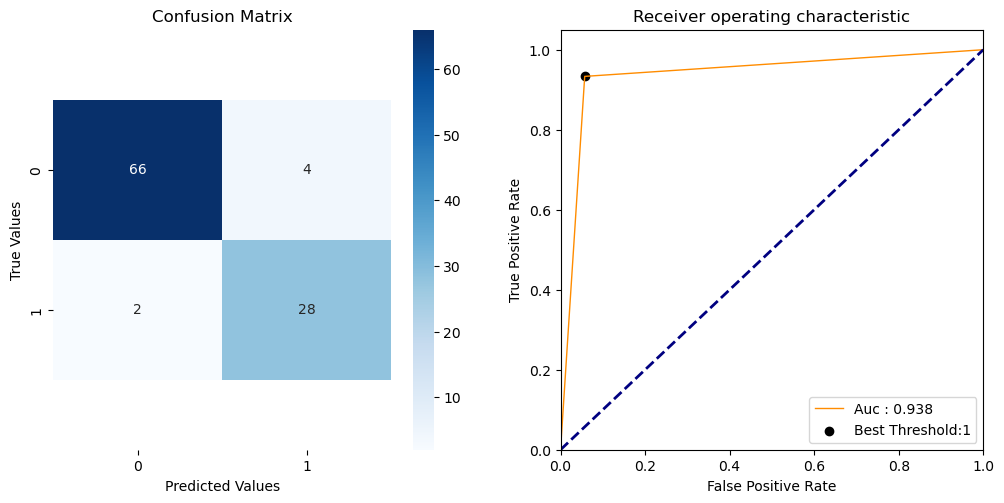

In [47]:
y_pred = (model.predict(x_test) > 0.5).astype("int32")
print_results(y_true.failure_lbl_1, y_pred)

In [48]:
confusion_matrix(y_train, (model.predict(x_train) > 0.5).astype("int32"))

array([[10484,   247],
       [   30,  4970]])

## Multiclass Classification

In [49]:
sequence_length = 50
mask_value = 0
label = "failure_lbl_2"


Let's prepare data using above functions.

In [50]:
#generate train
x_train=np.concatenate(list(list(gen_train(df_train[df_train['UnitNumber']==unit], sequence_length, feats)) for unit in df_train['UnitNumber'].unique()))
print(x_train.shape)

(15731, 50, 15)


In [63]:
#generate target of train
y_train = np.concatenate(list(list(gen_target(df_train[df_train['UnitNumber']==unit], sequence_length, label)) for unit in df_train['UnitNumber'].unique()))
print(y_train.shape)
y_train

(15731,)


array([0, 0, 0, ..., 2, 2, 2])

In [52]:
# vectorize y_train
y_train2 = to_categorical(y_train)
y_train2

array([[1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       ...,
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.]], dtype=float32)

In [53]:
#generate test
x_test=np.concatenate(list(list(gen_test(df_test[df_test['UnitNumber']==unit], sequence_length, feats, mask_value)) for unit in df_test['UnitNumber'].unique()))
print(x_test.shape)

(100, 50, 15)


In [54]:
nb_features = x_train.shape[2]
nb_out = 1

In [55]:
nb_features

15

In [56]:
cls_wt= class_weight.compute_class_weight(class_weight='balanced',classes=np.unique(y_train), y=y_train)
cls_wt = {i : cls_wt[i] for i in range(3)}
cls_wt

{0: 0.48864660019258843, 1: 2.0974666666666666, 2: 2.0974666666666666}

### Model

In [57]:
history2 = History()
model2 = Sequential()
model2.add(Conv1D(50, 6, activation = 'relu', input_shape=(sequence_length, nb_features)))
model2.add(Conv1D(50, 6, activation = 'relu'))
model2.add(MaxPooling1D(3))
model2.add(Conv1D(100, 6, activation = 'relu'))
model2.add(Conv1D(100, 6, activation = 'relu'))
model2.add(GlobalAveragePooling1D())
model2.add(Dropout(0.5))
model2.add(Dense(units=3, activation='softmax'))
model2.compile(loss="categorical_crossentropy", optimizer="adam", metrics=['accuracy'])
model2.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_8 (Conv1D)            (None, 45, 50)            4550      
_________________________________________________________________
conv1d_9 (Conv1D)            (None, 40, 50)            15050     
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 13, 50)            0         
_________________________________________________________________
conv1d_10 (Conv1D)           (None, 8, 100)            30100     
_________________________________________________________________
conv1d_11 (Conv1D)           (None, 3, 100)            60100     
_________________________________________________________________
global_average_pooling1d_2 ( (None, 100)               0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 100)              

In [58]:
%%time
# fit the model
model2.fit(x_train, y_train2, epochs=10, batch_size=64, validation_split=0.1, verbose=1, class_weight = cls_wt,
           callbacks=[history2, callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=3, verbose=0, mode='auto')])

Epoch 1/10


2022-11-05 18:19:51.585511: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


222/222 [==============================] - ETA: 0s - loss: 0.4763 - accuracy: 0.8281

2022-11-05 18:19:55.785703: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


222/222 [==============================] - 5s 17ms/step - loss: 0.4763 - accuracy: 0.8281 - val_loss: 0.2965 - val_accuracy: 0.8653
Epoch 2/10
222/222 [==============================] - 4s 16ms/step - loss: 0.2590 - accuracy: 0.9094 - val_loss: 0.2507 - val_accuracy: 0.8863
Epoch 3/10
222/222 [==============================] - 4s 16ms/step - loss: 0.1787 - accuracy: 0.9371 - val_loss: 0.2734 - val_accuracy: 0.8945
Epoch 4/10
222/222 [==============================] - 4s 16ms/step - loss: 0.1177 - accuracy: 0.9586 - val_loss: 0.3236 - val_accuracy: 0.8780
Epoch 5/10
222/222 [==============================] - 4s 16ms/step - loss: 0.0941 - accuracy: 0.9698 - val_loss: 0.2953 - val_accuracy: 0.9009
CPU times: user 15.6 s, sys: 7.38 s, total: 22.9 s
Wall time: 19 s


Text(0.5, 1.0, 'Loss')

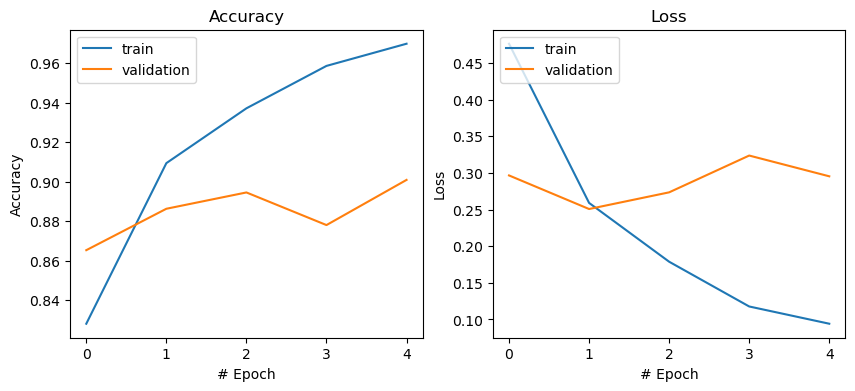

In [59]:
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (10, 4))
# Accuracy
ax[0].plot(history2.history['accuracy'])
ax[0].plot(history2.history['val_accuracy'])
ax[0].set_ylabel('Accuracy')
ax[0].set_xlabel('# Epoch')
ax[0].legend(['train', 'validation'], loc='upper left')
ax[0].set_title('Accuracy')
# Loss
ax[1].plot(history2.history['loss'])
ax[1].plot(history2.history['val_loss'])
ax[1].set_ylabel('Loss')
ax[1].set_xlabel('# Epoch')
ax[1].legend(['train', 'validation'], loc='upper left')
ax[1].set_title('Loss')

F1 Score:  0.8824453950353232
              precision    recall  f1-score   support

           0       0.99      0.97      0.98        70
           1       0.69      0.82      0.75        11
           2       0.94      0.89      0.92        19

    accuracy                           0.94       100
   macro avg       0.87      0.89      0.88       100
weighted avg       0.95      0.94      0.94       100



2022-11-05 18:21:21.650353: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


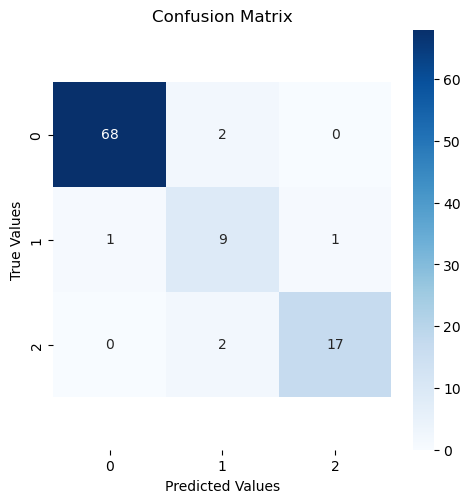

In [60]:
y_pred = np.argmax(model2.predict(x_test), axis=-1)
print_results(y_true.failure_lbl_2, y_pred, multi_class=True)

In [61]:
confusion_matrix(y_train, np.argmax(model2.predict(x_train), axis=-1))

array([[10634,    97,     0],
       [  145,  2303,    52],
       [    0,   203,  2297]])